In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import info_map
from scripts.arena import Arena, Aperture, Mouse, visualize_arena
from tqdm import tqdm
import os

In [9]:
arena = Arena(length=60, width=60, height=50)
aperture = Aperture(arena_width=60, arena_height=50, arena_length=60, gap_width=10)
circleL = (arena.width/2 - aperture.gap_width, arena.width, arena.height/2)
circleR = (arena.width/2 + aperture.gap_width, arena.width, arena.height/2)



In [49]:
def get_visibility(source, target, aperture):
    v_t2Lwall = np.subtract(aperture.left_wall_edge + (target[2],), target)
    v_t2Lwall = v_t2Lwall/np.linalg.norm(v_t2Lwall)
    v_t2Rwall = np.subtract(aperture.right_wall_edge + (target[2],), target)
    v_t2Rwall = v_t2Rwall/np.linalg.norm(v_t2Rwall)

    # Vector from target to source (normalized)
    v_t2s = np.subtract(source, target)
    v_t2s = v_t2s / np.linalg.norm(v_t2s)

    # Cross products to determine the relative position of v_target2source
    cross_LS = np.cross(v_t2Lwall[:2], v_t2s[:2])
    cross_RS = np.cross( v_t2s[:2], v_t2Rwall[:2],)
    # Check if v_target2source is between the left and right wall vectors

    if cross_LS >=0 and cross_RS >=0:
        return True
    else:
        return False


def get_visible_area(source, circle_center, radius, aperture):
    """
    Calculate the visible area of a circle from a given point by checking the visibility
    of various points on the circle's perimeter.
    """
    d_theta = np.pi/180  # Increase for higher accuracy
    angles = np.arange(0, 2 * np.pi, d_theta)
    visible_angles = []
    
    for i in range(len(angles)-1):
        # Parametrize the circle
        x_circle = circle_center[0] + radius * np.cos(angles[i])
        z_circle = circle_center[2] + radius * np.sin(angles[i])
        y_circle = circle_center[1]  # Y remains the same for a circle in the YZ plane
        
        circle_point = (x_circle, y_circle, z_circle)
        flag = get_visibility(source, circle_point, aperture)
        if flag:
            visible_angles.append(angles[i])
    #print(len(angles), len(visible_angles))
    area  = get_segment_area(visible_angles, radius)
    return area

def get_segment_area(angles, radius):
    if len(angles)==0:
        return (0, 0)
    else:
        # Sort the angles
        angles = np.sort(angles)
        
        # Calculate the differences between consecutive angles
        diffs = np.diff(angles, append=angles[0] + 2 * np.pi - angles[-1])
        
        # Find the largest gap, which is the central angle of the segment
        central_angle = np.max(diffs)
            
        # Calculate the area of the circular segment
        # Area of segment = 0.5 * radius^2 * (theta - sin(theta))
        area = 0.5 * radius**2 * (central_angle - np.sin(central_angle))

        # area compliment 
        area_c = np.pi*radius**2 - area
        return np.sort(np.array([area, area_c]))
    
def infoMetric(area1, area2):
    return 0.5 * np.abs(area1 + area2)

def info_map(arena, circle1_center, circle2_center, aperture, radius):
    x_resolution = 60
    y_resolution = 60

    x = np.linspace(0, arena.length, x_resolution)
    y = np.linspace(0, arena.width, y_resolution)

    info_mat = np.zeros((x_resolution, y_resolution))
    print(info_mat.shape, '\n')
    # Iterate through a grid of points in the arena
    for i in tqdm(range(x_resolution)):
        for j in range(y_resolution):
            source = (x[i], y[j], 20)
            area_circle1 = get_visible_area(source, circle1_center, radius, aperture)
            area_circle2 = get_visible_area(source, circle2_center, radius, aperture)

            # Check whether to use major or minor segment area

            # larger element of area_circle is last element
            if source[0] > arena.length/2:
                A1 = area_circle1[1]
                A2 = area_circle2[0]
            elif source[0] < arena.length/2:
                A1 = area_circle1[0]
                A2 = area_circle2[1]
            else: 
                A1 = area_circle1[0]
                A2 = area_circle2[0]    

            info_mat[i, j] = infoMetric(A1, A2) 
    return info_mat

In [48]:
source = (10, 0, 20)
target = (40, 60, 25)
x=get_visible_area(source, circleL, 5, aperture)
v = get_visibility(source, target, aperture)
print(x)
a =get_segment_area(x, 5)
print(a[1])


360 132
[0.0, 0.017453292519943295, 0.03490658503988659, 0.05235987755982989, 0.06981317007977318, 0.08726646259971647, 0.10471975511965978, 0.12217304763960307, 0.13962634015954636, 0.15707963267948966, 0.17453292519943295, 0.19198621771937624, 0.20943951023931956, 0.22689280275926285, 0.24434609527920614, 0.2617993877991494, 0.2792526803190927, 0.29670597283903605, 0.3141592653589793, 0.33161255787892263, 0.3490658503988659, 0.3665191429188092, 0.3839724354387525, 0.4014257279586958, 0.4188790204786391, 0.4363323129985824, 0.4537856055185257, 0.47123889803846897, 0.4886921905584123, 0.5061454830783556, 0.5235987755982988, 0.5410520681182421, 0.5585053606381855, 0.5759586531581288, 0.5934119456780721, 0.6108652381980153, 0.6283185307179586, 0.6457718232379019, 0.6632251157578453, 0.6806784082777885, 0.6981317007977318, 0.7155849933176751, 0.7330382858376184, 0.7504915783575618, 0.767944870877505, 0.7853981633974483, 0.8028514559173916, 0.8203047484373349, 0.8377580409572782, 0.8552113

In [50]:
info_mat = info_map(arena, circleL, circleR, aperture, radius=5)


(60, 60) 



100%|██████████| 60/60 [01:45<00:00,  1.76s/it]


In [53]:
BASE_PATH = "/Users/reecekeller/Documents/Xaq/act_sense/act_sense/data/"
np.save(os.path.join(BASE_PATH, 'info_matrix.npy'), info_mat)


In [54]:
info_map = np.load(BASE_PATH + 'info_matrix.npy')

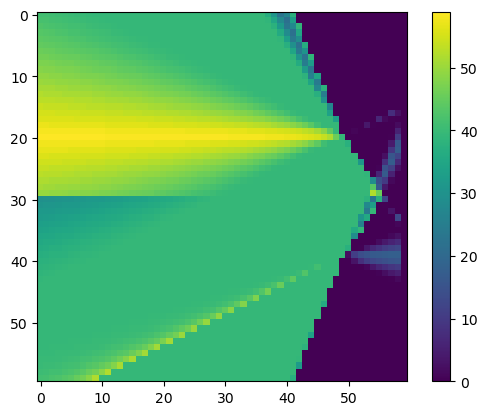

In [55]:
plt.imshow(info_map)
plt.colorbar()
plt.show()
